In [12]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm
from utils.combine_tools import apply_qc
from utils.plot_utils import combine_pdf_big
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
from aind_ephys_utils import align
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
criteria_name = 'beh_all'
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
    


Applying bounds for isi_violations: [0.0, 0.1]
 - isi_violations: 17847 -> 8148 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8148 -> 5771 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5771 -> 5748 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 5748 -> 4224 units passed
Applying items for in_df: [True]
 - in_df: 4224 -> 4224 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 307
Number of non-opto units after filtering: 4224


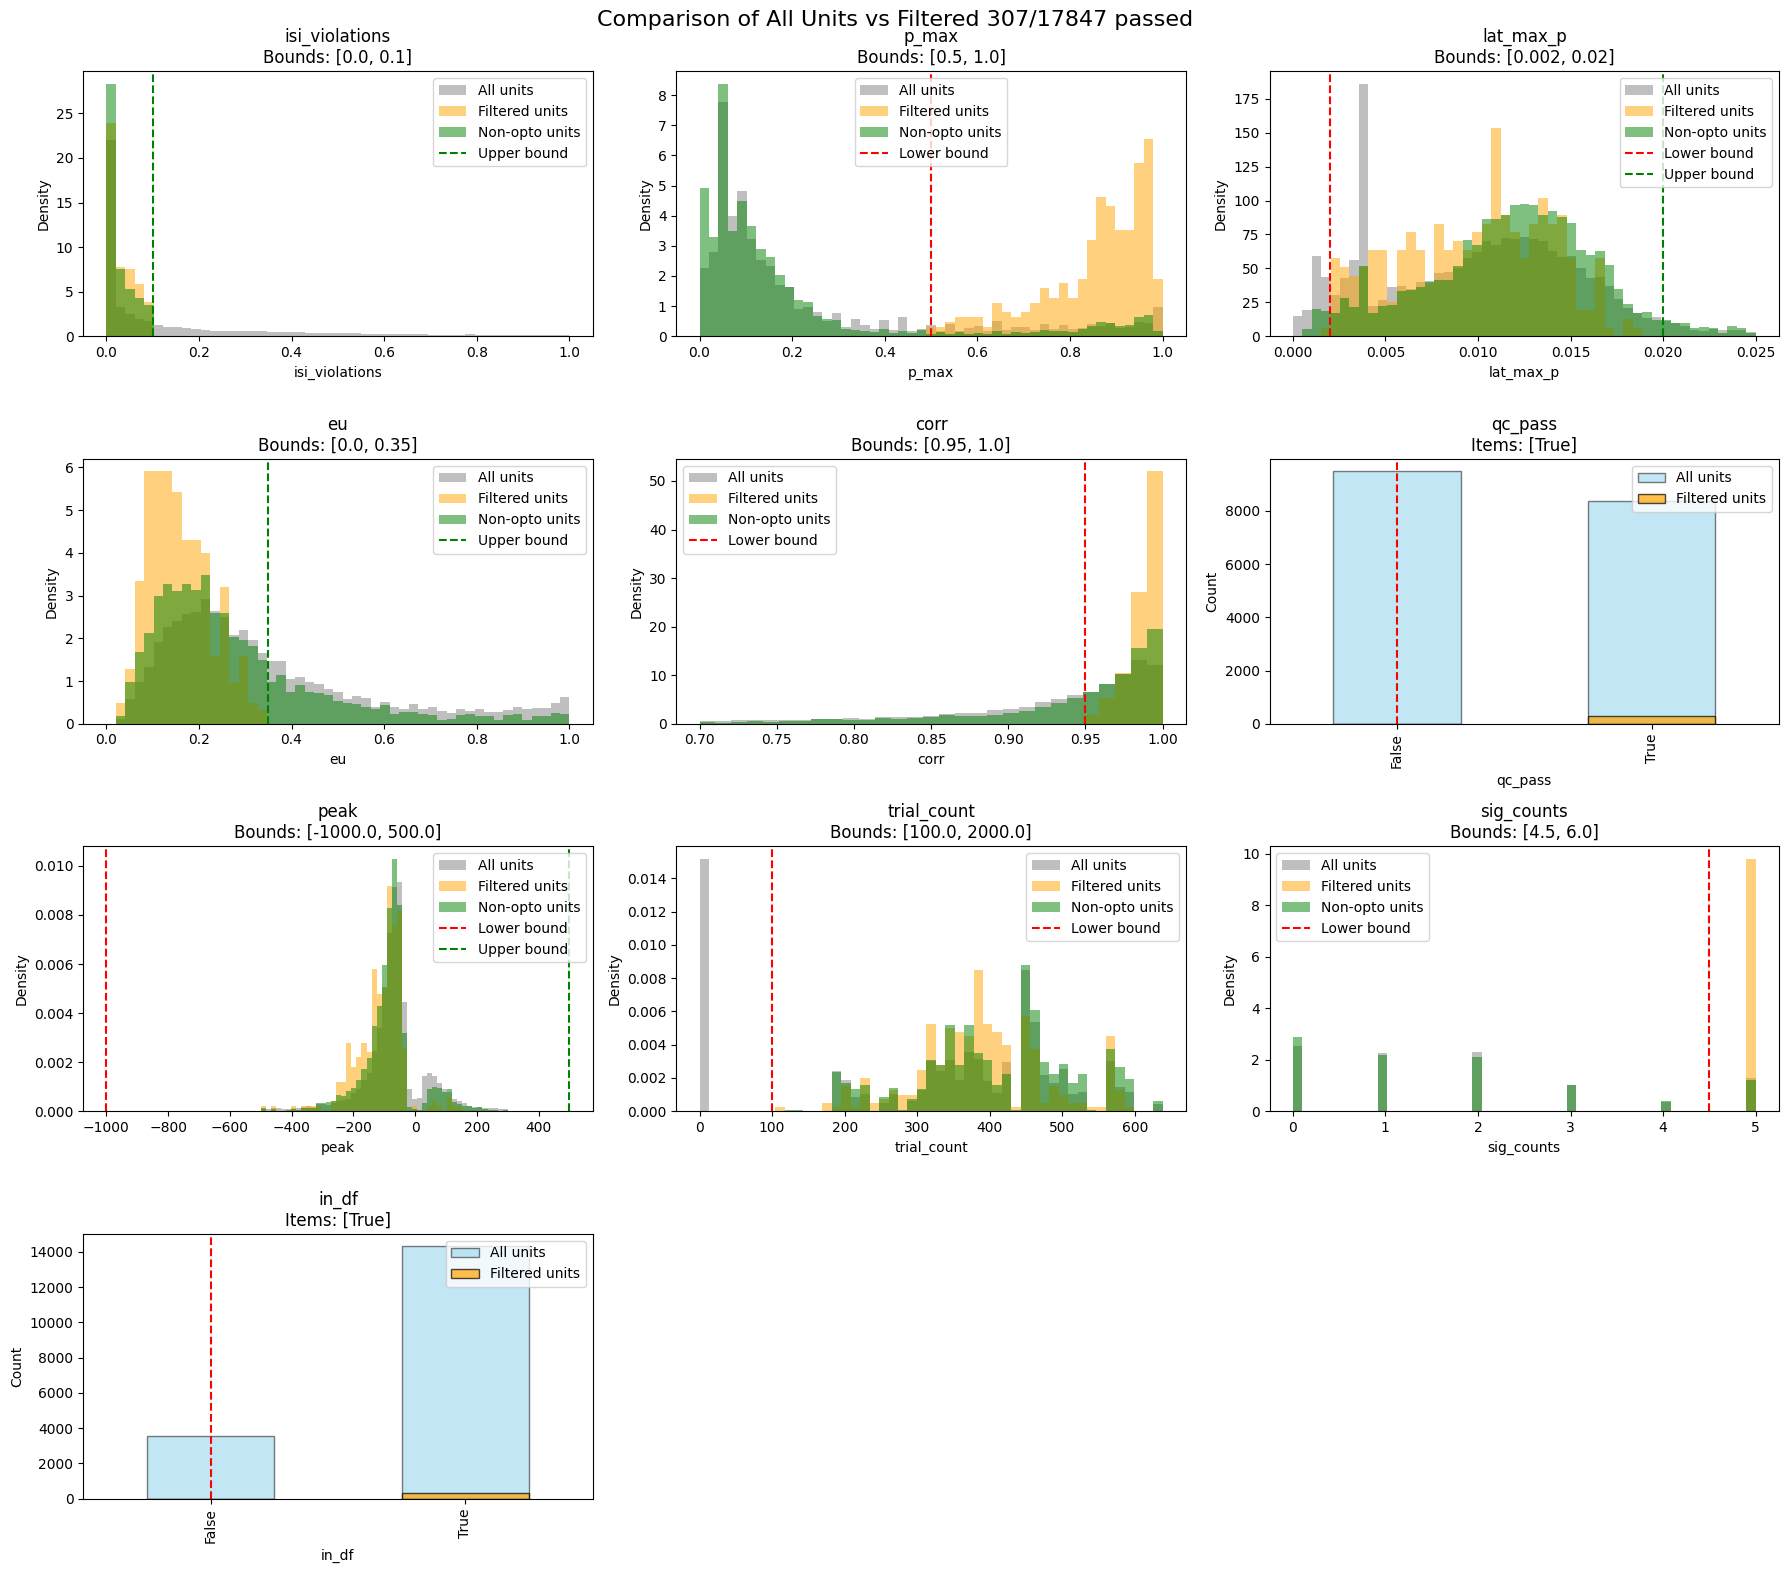

In [3]:
# start with a mask of all True
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)


In [11]:
# grab all tagged units and combine a pdf
data_type = 'curated'
target = 'soma'
wf_folder = beh_folder
opto_folder = os.path.join(wf_folder, 'opto_tagged')
wf_check_folder = os.path.join(wf_folder, 'waveforms_check')
behavior_go_folder = os.path.join(wf_folder, 'behavior_tagged_go_cue')
behavior_response_folder = os.path.join(wf_folder, 'behavior_tagged_response')
burst_folder = os.path.join(wf_folder, 'burst')
drift_folder = os.path.join(wf_folder, 'drift')
alignment_folder = os.path.join(wf_folder, 'alignment_compare')
anti_opto_folder = os.path.join(wf_folder, 'anti_opto')
anti_behavior_folder = os.path.join(wf_folder, 'anti_behavior')
shutil.rmtree(opto_folder, ignore_errors=True)
shutil.rmtree(behavior_go_folder, ignore_errors=True)
shutil.rmtree(behavior_response_folder, ignore_errors=True)
shutil.rmtree(anti_opto_folder, ignore_errors=True)
shutil.rmtree(anti_behavior_folder, ignore_errors=True)
shutil.rmtree(drift_folder, ignore_errors=True)
shutil.rmtree(path=wf_check_folder, ignore_errors=True)
shutil.rmtree(burst_folder, ignore_errors=True)
shutil.rmtree(alignment_folder, ignore_errors=True)

os.makedirs(name=opto_folder, exist_ok=True)
os.makedirs(name=behavior_go_folder, exist_ok=True)
os.makedirs(name=behavior_response_folder, exist_ok=True)
os.makedirs(name=anti_opto_folder, exist_ok=True)
os.makedirs(name=anti_behavior_folder, exist_ok=True)
os.makedirs(name=drift_folder, exist_ok=True)
os.makedirs(name=wf_check_folder, exist_ok=True)
os.makedirs(name=burst_folder, exist_ok=True)
os.makedirs(name=alignment_folder, exist_ok=True)

anti_cvs = '/root/capsule/code/data_management/antidromic_units.csv'
anti_df = pd.read_csv(anti_cvs)

for i, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    print(f'Processing session {session}, unit {row["unit"]}')
    unit = row['unit']
    session_dir = session_dirs(session)
    # opto_file
    all_pdfs = os.listdir(session_dir[f'opto_dir_fig_{data_type}'])
    pdf = [pdf for pdf in all_pdfs if f'unit_{int(unit)}_' in pdf and pdf.endswith('.pdf')]
    if len(pdf) == 0:
        print(f'No opto pdf found for {session}, {unit}')
        continue
    else:
        pdf = pdf[0]
    pdf_path = os.path.join(session_dir[f'opto_dir_fig_{data_type}'], pdf)
    # copy to new path
    new_path_opto = os.path.join(opto_folder, f'{session}_{pdf}')
    _ = shutil.copy(pdf_path, new_path_opto)   
    # if ~np.isnan(row['anti_resp']):
    #     new_path_opto = os.path.join(anti_opto_folder, f'{session}_{row["proj"]}_tier_{row["anti_resp"]}_{pdf}')
    #     _ = shutil.copy(pdf_path, new_path_opto)
    #     if anti_df.query("session == @session and unit_id == @unit").empty:
    #         print(f'Error anti unit found for {session}, {unit}')
    #     elif len(anti_df.query("session == @session and unit_id == @unit")) == 1:
    #         print(f'Correct anti unit found for {session}, {unit}')

    # selected_sessions.append(session)
    # selected_units.append(unit)
    # all_pdf.append(pdf_path)
    
    # drift file
    drift_dir = os.path.join(session_dir[f'opto_dir_{data_type}'], 'drift')
    if not os.path.exists(drift_dir):
        print(f'No drift directory found for {session}, {unit}')
    else: 
        all_pdfs = os.listdir(drift_dir)
        pdf = [pdf for pdf in all_pdfs if f'{int(unit)}_drift' in pdf and pdf.endswith('.pdf')]
        if len(pdf) == 0:
            pdf = [pdf for pdf in all_pdfs if f'{int(unit)}.0_drift' in pdf and pdf.endswith('.pdf')]
            if len(pdf) == 0:
                print(f'No drift pdf found for {session}, {unit}')
                continue
            else:
                pdf=pdf[0]
        else:
            pdf = pdf[0]
        pdf_path = os.path.join(drift_dir, pdf)
        # copy to new path
        new_path_opto = os.path.join(drift_folder, f'{session}_{pdf}')
        _ = shutil.copy(pdf_path, new_path_opto)    

    # waveform file
    wf_dir = os.path.join(session_dir['ephys_fig_dir_curated'], 'waveforms_check')
    if not os.path.exists(wf_dir):
        print(f'No waveform directory found for {session}, {unit}')
    else: 
        all_pdfs = os.listdir(wf_dir)
        pdf = [pdf for pdf in all_pdfs if f'{int(unit)}_waveforms' in pdf and pdf.endswith('.pdf')]
        if len(pdf) == 0:
            pdf = [pdf for pdf in all_pdfs if f'{int(unit)}.0_waveforms' in pdf and pdf.endswith('.pdf')]
            if len(pdf) == 0:
                print(f'No waveform pdf found for {session}, {unit}')
                continue
            else:
                pdf=pdf[0]
        else:
            pdf = pdf[0]
        pdf_path = os.path.join(wf_dir, pdf)
        # copy to new path
        new_path_opto = os.path.join(wf_check_folder, f'{session}_{pdf}')
        _ = shutil.copy(pdf_path, new_path_opto)

 
    if row['in_df']:
        beh_go_dir = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue')
        beh_response_dir = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'response')
        burst_dir = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'],'burst')
        align_dir = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue_vs_response')
        # go cue alignment
        if not os.path.exists(beh_go_dir):
            print(f'No go_cue directory found for {session}, {unit}')
        else: 
            all_pdfs = os.listdir(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue'))
            pdf = [pdf for pdf in all_pdfs if f'unit_{int(unit)}_' in pdf and pdf.endswith('.pdf')]
            if len(pdf) == 0:
                print(f'No go_cue pdf found for {session}, {unit}')
                continue
            else:
                pdf = pdf[0]
                pdf_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue', pdf)
                # copy to new path
                new_path_ephys = os.path.join(behavior_go_folder, f'{session}_{pdf}')
                _ = shutil.copy(pdf_path, new_path_ephys)
        # response alignment
        if not os.path.exists(beh_response_dir):
            print(f'No response directory found for {session}, {unit}')
        else: 
            all_pdfs = os.listdir(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'response'))
            pdf = [pdf for pdf in all_pdfs if f'unit_{int(unit)}_' in pdf and pdf.endswith('.pdf')]
            if len(pdf) == 0:
                print(f'No response pdf found for {session}, {unit}')
                continue
            else:
                pdf = pdf[0]
                pdf_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'response', pdf)
                # copy to new path
                new_path_ephys = os.path.join(behavior_response_folder, f'{session}_{pdf}')
                _ = shutil.copy(pdf_path, new_path_ephys)
        # burst
        if not os.path.exists(burst_dir):
            print(f'No burst directory found for {session}, {unit}')
        else: 
            all_pdfs = os.listdir(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'burst'))
            pdf = [pdf for pdf in all_pdfs if f'{int(unit)}_burst' in pdf and pdf.endswith('.pdf')]
            if len(pdf) == 0:
                pdf = [pdf for pdf in all_pdfs if f'{int(unit)}.0_burst' in pdf and pdf.endswith('.pdf')]
            if len(pdf)==0:
                print(f'No burst pdf found for {session}, {unit}')
                continue
            else:
                pdf = pdf[0]
                pdf_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'burst', pdf)
                # copy to new path
                new_path_ephys = os.path.join(burst_folder, f'{session}_{pdf}')
                _ = shutil.copy(pdf_path, new_path_ephys)
        # alignment compare
        if not os.path.exists(align_dir):
            print(f'No alignment compare directory found for {session}, {unit}')
        else: 
            all_pdfs = os.listdir(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue_vs_response'))
            pdf = [pdf for pdf in all_pdfs if f'{int(unit)}_' in pdf and pdf.endswith('.pdf')]
            if len(pdf) == 0:
                pdf = [pdf for pdf in all_pdfs if f'{int(unit)}.0_' in pdf and pdf.endswith('.pdf')]
            if len(pdf) == 0:
                print(f'No alignment compare pdf found for {session}, {unit}')
                continue
            else:
                pdf = pdf[0]
                pdf_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue_vs_response', pdf)
                # copy to new path
                new_path_ephys = os.path.join(alignment_folder, f'{session}_{pdf}')
                _ = shutil.copy(pdf_path, new_path_ephys)

        # if ~np.isnan(row['anti_resp']):
        #     new_path_ephys = os.path.join(anti_behavior_folder, f'{session}_{row["proj"]}_tier_{row["anti_resp"]}_{pdf}')
        #     _ = shutil.copy(pdf_path, new_path_ephys)


Processing session behavior_716325_2024-05-31_10-31-14, unit 87.0
Selected experiment1 recording1, length:6585.81
Processing session behavior_716325_2024-05-31_10-31-14, unit 377.0
Selected experiment1 recording1, length:6585.81
Processing session behavior_716325_2024-05-31_10-31-14, unit 379.0
Selected experiment1 recording1, length:6585.81
Processing session behavior_717121_2024-06-15_10-00-58, unit 162.0
Selected experiment1 recording1, length:5996.10
Processing session behavior_751004_2024-12-19_11-50-37, unit 297.0
Selected experiment1 recording1, length:5325.20
Processing session behavior_751004_2024-12-20_13-26-11, unit 40.0
Selected experiment1 recording1, length:4823.22
Processing session behavior_751004_2024-12-20_13-26-11, unit 263.0
Selected experiment1 recording1, length:4823.22
Processing session behavior_751004_2024-12-20_13-26-11, unit 268.0
Selected experiment1 recording1, length:4823.22
Processing session behavior_751004_2024-12-21_13-28-28, unit 6.0
Selected experime

In [14]:
combine_pdf_big(alignment_folder, os.path.join(wf_folder, 'alignment_compare.pdf'))

Processing 101 files in /root/capsule/scratch/combined/beh_plots/beh_all/alignment_compare
Combined PDF saved as: /root/capsule/scratch/combined/beh_plots/beh_all/alignment_compare.pdf


In [4]:
def regressors_to_formula(response_var, regressors):
    terms = [r for r in regressors if r != 'Intercept']
    has_intercept = 'Intercept' in regressors
    rhs = '1' if has_intercept else '0'
    if terms:
        rhs += ' + ' + ' + '.join(terms)
    return f'{response_var} ~ {rhs}'

# Excluding no go trials

In [5]:
# get all t-stats, coeffs, p-values 
data_type = 'curated'
target = 'soma'
all_coefs = []
all_T = []
all_p = []
align_name = 'go_cue'
regressors_focus = ['lick_lat', 'ipsi', 'lick_lat:ipsi', 'svs']
regressors_sup = ['Intercept']
all_regressors = regressors_focus + regressors_sup
formula = regressors_to_formula('spikes', all_regressors)

curr_session = None
pre_event = -1.5
post_event = 3.5
model_name = 'stan_qLearning_5params'
binSize = 0.1
loaded_session = None
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    # check if different session
    if loaded_session is None or loaded_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = makeSessionDF(session, model_name = model_name)
        session_df['ipsi'] = 2*(session_df['choice'].values - 0.5) * row['rec_side']
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
        print(f'Loaded session: {session}')
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    if 'amp_abs' in all_regressors or 'amp' in all_regressors:
        # get unit_trial_drift_curr's rows corresponding to the ones in session_df_curr
        session_df_curr = session_df_curr.merge(unit_trial_drift_curr, on='trial_ind', how='left').copy()
    if align_name == 'go_cue':
        align_time = session_df_curr['go_cue_time'].values
        # align_time_all = tblTrials_curr['goCue_start_time'].values
    elif align_name == 'response':
        align_time = session_df_curr['choice_time'].values
        # align_time_all = tblTrials_curr['reward_outcome_time'].values
    # spike_matrix, slide_times = get_spike_matrix(spike_times_curr, align_time, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    spike_matrix_LM, slide_times_LM = get_spike_matrix(spike_times_curr, align_time, 
                                                pre_event=pre_event, post_event=post_event, 
                                                binSize=binSize, stepSize=0.1)
    # spike_matrix_all, slide_times = get_spike_matrix(spike_times_curr, align_time_all, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    spike_matrix_LM = zscore(spike_matrix_LM, axis=0)  
    
    # try:
    regressors, curr_T, curr_p, curr_coefs = fitSpikeModelG(session_df_curr, spike_matrix_LM, formula)
    # pick regressors from regressors_focus list, sort them according to sequence in regressors_focus
    focus_ind = [regressors.index(r) for r in regressors_focus if r in regressors]
    curr_T = [T_t[focus_ind] for T_t in curr_T]
    curr_p = [p_t[focus_ind] for p_t in curr_p]
    curr_coefs = [coef_t[focus_ind] for coef_t in curr_coefs] 

    if len(curr_T) == 4:
        print(f'Session: {session}, Unit: {unit_id}')

    all_coefs.append(curr_coefs)
    all_T.append(curr_T)
    all_p.append(curr_p)

Loaded session: behavior_716325_2024-05-31_10-31-14
Loaded session: behavior_717121_2024-06-15_10-00-58
Loaded session: behavior_751004_2024-12-19_11-50-37
Loaded session: behavior_751004_2024-12-20_13-26-11
Loaded session: behavior_751004_2024-12-21_13-28-28
Loaded session: behavior_751004_2024-12-22_13-09-17
Loaded session: behavior_751004_2024-12-23_14-20-03
Loaded session: behavior_751769_2025-01-16_11-32-05
Loaded session: behavior_751769_2025-01-17_11-37-39
Loaded session: behavior_751769_2025-01-18_10-15-25
Loaded session: behavior_758017_2025-02-04_11-57-38
Loaded session: behavior_758017_2025-02-05_11-42-34
Loaded session: behavior_758017_2025-02-06_11-26-14
Loaded session: behavior_758017_2025-02-07_14-11-08
Loaded session: behavior_751766_2025-02-11_11-53-38
Loaded session: behavior_751766_2025-02-13_11-31-21
Loaded session: behavior_751766_2025-02-14_11-37-11
Loaded session: behavior_751181_2025-02-25_12-12-35
Loaded session: behavior_751181_2025-02-26_11-51-19
Loaded sessi

In [6]:
all_coefsm = np.array(all_coefs)
all_Tm = np.array(all_T)
all_pm = np.array(all_p)

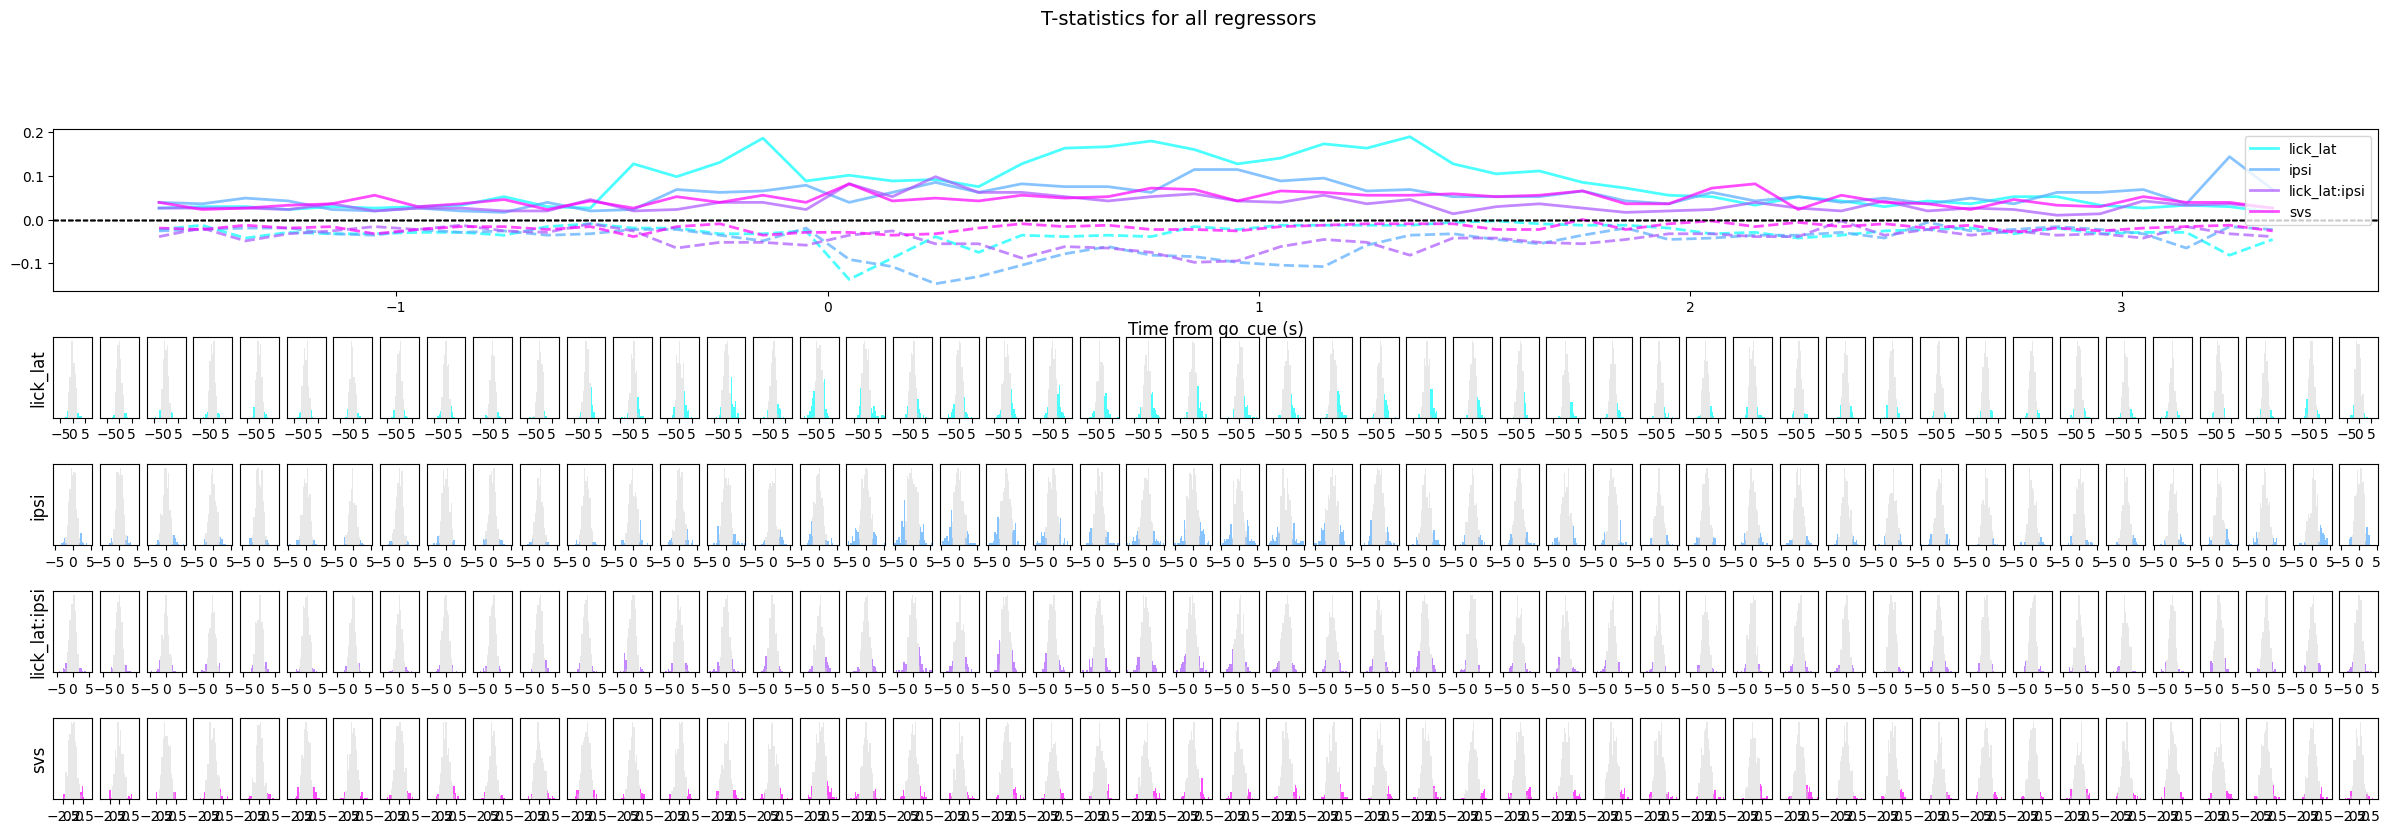

In [7]:
fig = plt.figure(figsize=(30, 12))
sig_thresh = 1
gs = gridspec.GridSpec(len(regressors_focus)+3, len(slide_times_LM), figure=fig, hspace=0.5, height_ratios=[2] + [1]*len(regressors_focus) + [1, 1])
cmap = plt.cm.cool  # Get the colormap
colors = cmap(np.linspace(0, 1, len(regressors_focus)))
ax_all = fig.add_subplot(gs[0, :]) 
for reg_ind, regressor in enumerate(regressors_focus):
    x_limit = np.max(np.abs(all_Tm[:, :, reg_ind]))
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[reg_ind+1, time_ind])
        curr_Ts = all_Tm[:, time_ind, reg_ind]  # get the T-statistics for the current regressor and time
        curr_Ps = all_pm[:, time_ind, reg_ind]  # get the p-values for the current regressor and time
        bins = np.linspace(-x_limit-0.01, x_limit+0.01, 30)
        ax.hist(curr_Ts[curr_Ps<0.05], bins=bins, color=colors[reg_ind], alpha=0.7, edgecolor='none')  # plot T-statistics with p<0.05
        ax.hist(curr_Ts[curr_Ps>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
        ax.set_xlim(-x_limit, x_limit)
        if time_ind == 0:
            ax.set_ylabel(f'{regressor}', fontsize=12)
        # turn off y-ticks and x-ticks
        ax.set_yticks([])
        # ax.set_xticks([])

    curr_Ps = np.squeeze(all_pm[:, :, reg_ind])
    curr_Ts = all_Tm[:, :, reg_ind]
    # check if any p-values are below 0.05
    curr_Ps_sig_pos = np.nanmean((curr_Ps<0.05)&(curr_Ts>0), axis = 0) 
    curr_Ps_sig_neg = -np.nanmean((curr_Ps<0.05)&(curr_Ts<0), axis = 0)   
    ax_all.plot(slide_times_LM, curr_Ps_sig_pos, color=colors[reg_ind], alpha=0.7, linewidth=2, label=regressor)  # plot the proportion of significant p-values over time
    ax_all.plot(slide_times_LM, curr_Ps_sig_neg, color=colors[reg_ind], alpha=0.7, linewidth=2, linestyle='--')  # plot the proportion of significant p-values over time
    ax_all.legend(loc='upper right', fontsize=10)
    ax_all.set_xlabel(f'Time from {align_name} (s)', fontsize=12)
    ax_all.axhline(0, color='k', linestyle='--', linewidth=1)  # add a horizontal line at y=0

if 'outcome' in regressors_focus:
    reward_ind = np.where(np.array(regressors_focus) == 'outcome')[0][0]  # find the index of the reward outcome
    q_ind = np.where(np.array(regressors_focus) == 'Qchosen')[0][0]  # find the index of the Qchosen
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[-1, time_ind])
        curr_T_reward = all_Tm[:, time_ind, reward_ind]  # get the T-statistics for the reward outcome
        curr_T_q = all_Tm[:, time_ind, q_ind]  # get the T-statistics for the Qchosen
        curr_coefs_reward = all_coefsm[:, time_ind, reward_ind]  # get the coefficients for the reward outcome
        curr_coefs_q = all_coefsm[:, time_ind, q_ind]  # get the coefficients for the Qchosen
        curr_p_reward = all_pm[:, time_ind, reward_ind]  # get the p-values for the reward outcome
        ax.scatter(curr_coefs_reward[curr_p_reward<sig_thresh], curr_coefs_q[curr_p_reward<sig_thresh], alpha=0.25, color='k', edgecolors='none', s=20)
        ax.set_xlabel(f'{time:.2f} s')
        limit = np.max([np.nanmax(np.abs(curr_coefs_reward)), np.nanmax(np.abs(curr_coefs_q))])
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)

        # polar

        all_vec = np.column_stack((curr_coefs_reward[curr_p_reward<sig_thresh], curr_coefs_q[curr_p_reward<sig_thresh]))  # combine the coefficients for the reward outcome and Qchosen]))

        # Convert Cartesian coordinates to polar coordinates
        theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])

        # Define histogram edges (bins) from -π to π
        edges = np.linspace(-np.pi, np.pi, 4*4)

        # Create polar histogram
        ax = fig.add_subplot(gs[-2, time_ind], polar=True)
        ax.hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=True)
        ax.set_yticks([])

plt.suptitle('T-statistics for all regressors', fontsize=14)
plt.savefig(os.path.join(beh_folder, f'Regression_in_time_{criteria_name}_{align_name}.pdf'), bbox_inches='tight')

# Including no go trials

In [8]:
# get all t-stats, coeffs, p-values for the two groups
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
all_coefs = []
all_T = []
all_p = []
align_name = 'go_cue'
regressors_focus = ['hit', 'amp']
regressors_sup = ['Intercept']
all_regressors = regressors_focus + regressors_sup
formula = regressors_to_formula('spikes', all_regressors)

curr_session = None
pre_event = -1.5
post_event = 3.5
model_name = 'stan_qLearning_5params'
binSize = 0.1
loaded_session = None
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    # check if different session
    if loaded_session is None or loaded_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = get_session_tbl(session)
        session_df['hit'] = session_df['animal_response'] != 2
        session_df['trial_ind'] = np.arange(len(session_df))
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
        print(f'Loaded session: {session}')
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    if 'amp_abs' in all_regressors or 'amp' in all_regressors:
        # get unit_trial_drift_curr's rows corresponding to the ones in session_df_curr
        session_df_curr = session_df_curr.merge(unit_trial_drift_curr, on='trial_ind', how='left').copy()
    if align_name == 'go_cue':
        if 'go_cue' in session_df_curr.columns:
            align_time = session_df_curr['go_cue'].values
        else:
            align_time = session_df_curr['goCue_start_time'].values
        # align_time_all = tblTrials_curr['goCue_start_time'].values
    elif align_name == 'response':
        if 'choice_time' in session_df_curr.columns:
            align_time = session_df_curr['choice_time'].values
        else:
            align_time = session_df_curr['reward_outcome_time'].values
        # align_time_all = tblTrials_curr['reward_outcome_time'].values
    # spike_matrix, slide_times = get_spike_matrix(spike_times_curr, align_time, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    spike_matrix_LM, slide_times_LM = get_spike_matrix(spike_times_curr, align_time, 
                                                pre_event=pre_event, post_event=post_event, 
                                                binSize=binSize, stepSize=min(0.25, binSize))
    # spike_matrix_all, slide_times = get_spike_matrix(spike_times_curr, align_time_all, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    spike_matrix_LM = zscore(spike_matrix_LM, axis=0)  
    
    # try:
    regressors, curr_T, curr_p, curr_coefs = fitSpikeModelG(session_df_curr, spike_matrix_LM, formula)
    # pick regressors from regressors_focus list, sort them according to sequence in regressors_focus
    focus_ind = [regressors.index(r) for r in regressors_focus if r in regressors]
    curr_T = [T_t[focus_ind] for T_t in curr_T]
    curr_p = [p_t[focus_ind] for p_t in curr_p]
    curr_coefs = [coef_t[focus_ind] for coef_t in curr_coefs] 

    if len(curr_T) == 4:
        print(f'Session: {session}, Unit: {unit_id}')

    all_coefs.append(curr_coefs)
    all_T.append(curr_T)
    all_p.append(curr_p)

Loaded session: behavior_716325_2024-05-31_10-31-14
Loaded session: behavior_717121_2024-06-15_10-00-58
Loaded session: behavior_751004_2024-12-19_11-50-37
Loaded session: behavior_751004_2024-12-20_13-26-11
Loaded session: behavior_751004_2024-12-21_13-28-28
Loaded session: behavior_751004_2024-12-22_13-09-17
Loaded session: behavior_751004_2024-12-23_14-20-03
Loaded session: behavior_751769_2025-01-16_11-32-05
Loaded session: behavior_751769_2025-01-17_11-37-39
Loaded session: behavior_751769_2025-01-18_10-15-25
Loaded session: behavior_758017_2025-02-04_11-57-38
Loaded session: behavior_758017_2025-02-05_11-42-34
Loaded session: behavior_758017_2025-02-06_11-26-14
Loaded session: behavior_758017_2025-02-07_14-11-08
Loaded session: behavior_751766_2025-02-11_11-53-38
Loaded session: behavior_751766_2025-02-13_11-31-21
Loaded session: behavior_751766_2025-02-14_11-37-11
Loaded session: behavior_751181_2025-02-25_12-12-35
Loaded session: behavior_751181_2025-02-26_11-51-19
Loaded sessi

In [9]:
all_coefsm = np.array(all_coefs)
all_Tm = np.array(all_T)
all_pm = np.array(all_p)

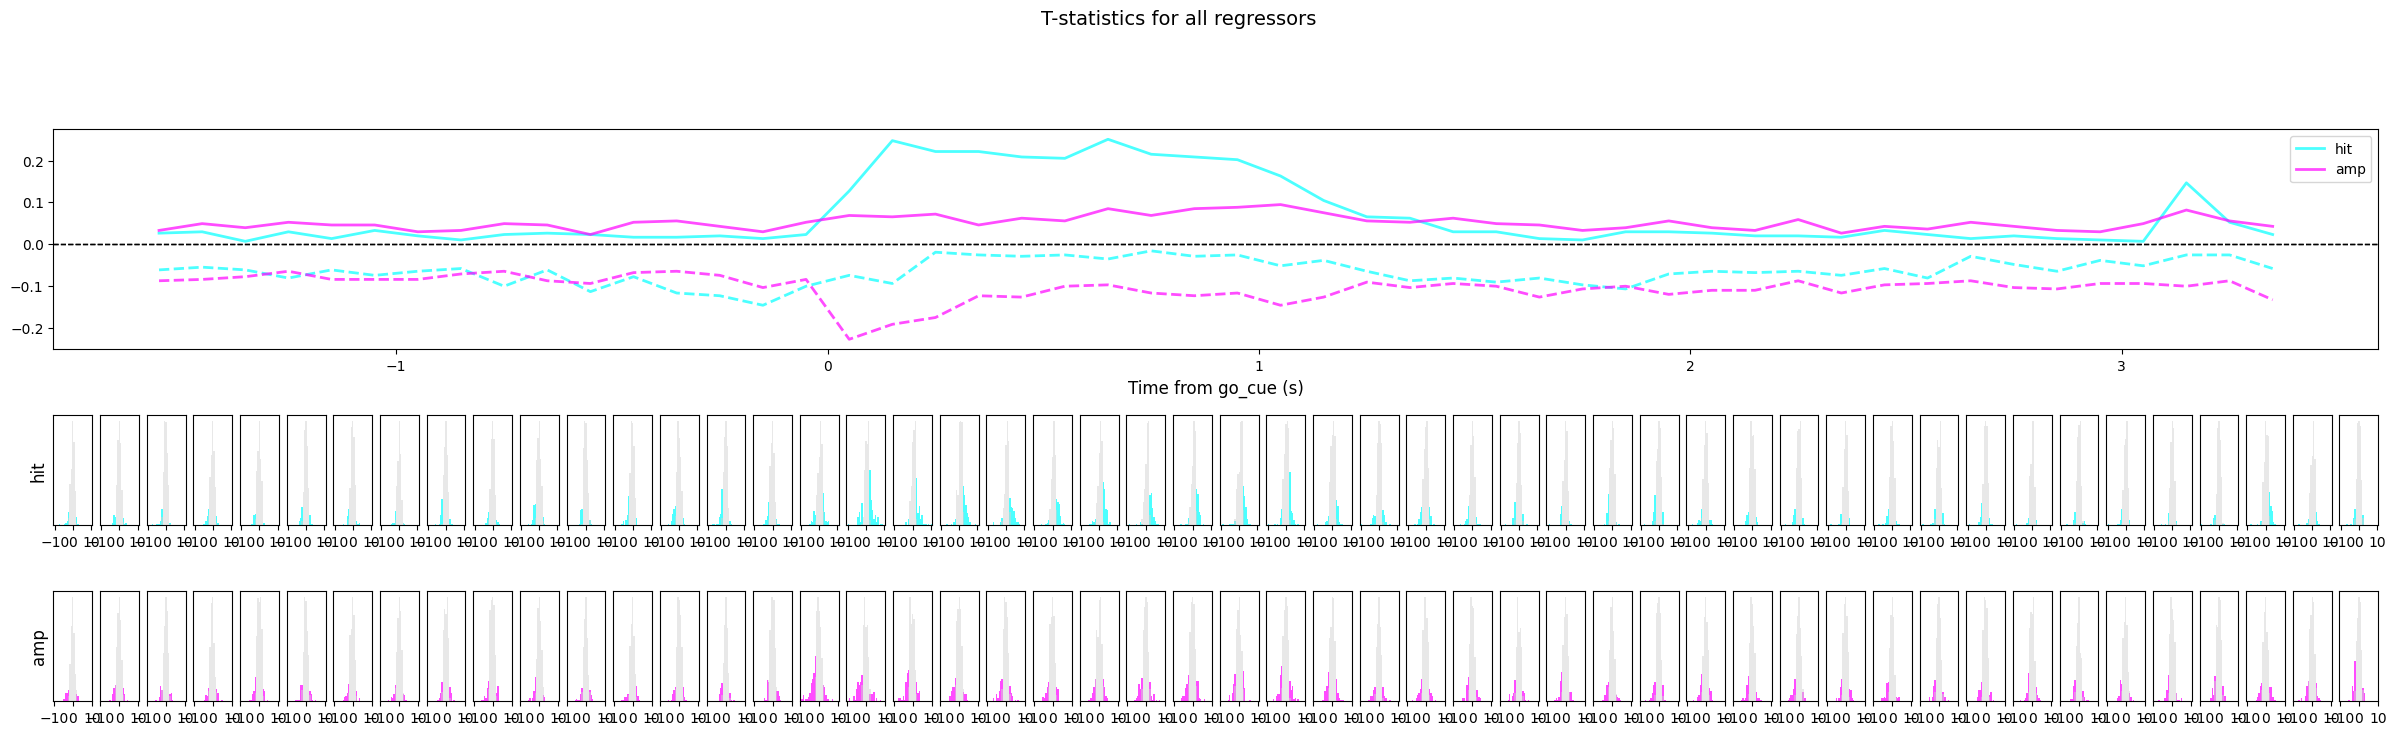

In [10]:
fig = plt.figure(figsize=(30, 12))
sig_thresh = 1
gs = gridspec.GridSpec(len(regressors_focus)+3, len(slide_times_LM), figure=fig, hspace=0.5, height_ratios=[2] + [1]*len(regressors_focus) + [1, 1])
cmap = plt.cm.cool  # Get the colormap
colors = cmap(np.linspace(0, 1, len(regressors_focus)))
ax_all = fig.add_subplot(gs[0, :]) 
for reg_ind, regressor in enumerate(regressors_focus):
    x_limit = np.max(np.abs(all_Tm[:, :, reg_ind]))
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[reg_ind+1, time_ind])
        curr_Ts = all_Tm[:, time_ind, reg_ind]  # get the T-statistics for the current regressor and time
        curr_Ps = all_pm[:, time_ind, reg_ind]  # get the p-values for the current regressor and time
        bins = np.linspace(-x_limit-0.01, x_limit+0.01, 30)
        ax.hist(curr_Ts[curr_Ps<0.05], bins=bins, color=colors[reg_ind], alpha=0.7, edgecolor='none')  # plot T-statistics with p<0.05
        ax.hist(curr_Ts[curr_Ps>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
        ax.set_xlim(-x_limit, x_limit)
        if time_ind == 0:
            ax.set_ylabel(f'{regressor}', fontsize=12)
        # turn off y-ticks and x-ticks
        ax.set_yticks([])
        # ax.set_xticks([])

    curr_Ps = np.squeeze(all_pm[:, :, reg_ind])
    curr_Ts = all_Tm[:, :, reg_ind]
    # check if any p-values are below 0.05
    curr_Ps_sig_pos = np.nanmean((curr_Ps<0.05)&(curr_Ts>0), axis = 0) 
    curr_Ps_sig_neg = -np.nanmean((curr_Ps<0.05)&(curr_Ts<0), axis = 0)   
    ax_all.plot(slide_times_LM, curr_Ps_sig_pos, color=colors[reg_ind], alpha=0.7, linewidth=2, label=regressor)  # plot the proportion of significant p-values over time
    ax_all.plot(slide_times_LM, curr_Ps_sig_neg, color=colors[reg_ind], alpha=0.7, linewidth=2, linestyle='--')  # plot the proportion of significant p-values over time
    ax_all.legend(loc='upper right', fontsize=10)
    ax_all.set_xlabel(f'Time from {align_name} (s)', fontsize=12)
    ax_all.axhline(0, color='k', linestyle='--', linewidth=1)  # add a horizontal line at y=0

if 'outcome' in regressors_focus:
    reward_ind = np.where(np.array(regressors_focus) == 'outcome')[0][0]  # find the index of the reward outcome
    q_ind = np.where(np.array(regressors_focus) == 'Qchosen')[0][0]  # find the index of the Qchosen
    for time_ind, time in enumerate(slide_times_LM):
        ax = fig.add_subplot(gs[-1, time_ind])
        curr_T_reward = all_Tm[:, time_ind, reward_ind]  # get the T-statistics for the reward outcome
        curr_T_q = all_Tm[:, time_ind, q_ind]  # get the T-statistics for the Qchosen
        curr_coefs_reward = all_coefsm[:, time_ind, reward_ind]  # get the coefficients for the reward outcome
        curr_coefs_q = all_coefsm[:, time_ind, q_ind]  # get the coefficients for the Qchosen
        curr_p_reward = all_pm[:, time_ind, reward_ind]  # get the p-values for the reward outcome
        ax.scatter(curr_coefs_reward[curr_p_reward<sig_thresh], curr_coefs_q[curr_p_reward<sig_thresh], alpha=0.25, color='k', edgecolors='none', s=20)
        ax.set_xlabel(f'{time:.2f} s')
        limit = np.max([np.nanmax(np.abs(curr_coefs_reward)), np.nanmax(np.abs(curr_coefs_q))])
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)

        # polar

        all_vec = np.column_stack((curr_coefs_reward[curr_p_reward<sig_thresh], curr_coefs_q[curr_p_reward<sig_thresh]))  # combine the coefficients for the reward outcome and Qchosen]))

        # Convert Cartesian coordinates to polar coordinates
        theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])

        # Define histogram edges (bins) from -π to π
        edges = np.linspace(-np.pi, np.pi, 4*4)

        # Create polar histogram
        ax = fig.add_subplot(gs[-2, time_ind], polar=True)
        ax.hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=True)
        ax.set_yticks([])

plt.suptitle('T-statistics for all regressors', fontsize=14)
plt.savefig(os.path.join(beh_folder, f'Regression_in_time_{criteria_name}_{align_name}.pdf'), bbox_inches='tight')

In [14]:
# get all t-stats, coeffs, p-values
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
all_coefs = []
all_T = []
all_p = []
align_name = 'go_cue'
regressors_focus = ['hit', 'amp']
regressors_sup = ['Intercept']
all_regressors = regressors_focus + regressors_sup
formula = regressors_to_formula('spikes', all_regressors)

curr_session = None
pre_event = -2
post_event = 0.3
model_name = 'stan_qLearning_5params'
loaded_session = None
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    # check if different session
    if loaded_session is None or loaded_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = get_session_tbl(session)
        session_df['hit'] = session_df['animal_response'] != 2
        session_df['trial_ind'] = np.arange(len(session_df))
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
        print(f'Loaded session: {session}')
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    if 'amp_abs' in all_regressors or 'amp' in all_regressors:
        # get unit_trial_drift_curr's rows corresponding to the ones in session_df_curr
        session_df_curr = session_df_curr.merge(unit_trial_drift_curr, on='trial_ind', how='left').copy()
    if align_name == 'go_cue':
        if 'go_cue' in session_df_curr.columns:
            align_time = session_df_curr['go_cue'].values
        else:
            align_time = session_df_curr['goCue_start_time'].values
        # align_time_all = tblTrials_curr['goCue_start_time'].values
    elif align_name == 'response':
        if 'choice_time' in session_df_curr.columns:
            align_time = session_df_curr['choice_time'].values
        else:
            align_time = session_df_curr['reward_outcome_time'].values
        # align_time_all = tblTrials_curr['reward_outcome_time'].values
    # spike_matrix, slide_times = get_spike_matrix(spike_times_curr, align_time, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    spikes_bl = align.to_events(spike_times_curr, align_time, (pre_event, 0), return_df=True)
    spikes_bl_count = spikes_bl.groupby('event_index').size()
    spikes_bl_rate = [spikes_bl_count.get(i, 0) for i in range(len(align_time))]/np.abs(pre_event)

    response = align.to_events(spike_times_curr, align_time, [0, post_event], return_df=True)
    response_count = response.groupby('event_index').size()
    response_rate = [response_count.get(i, 0) for i in range(len(align_time))]/np.abs(post_event)

    response_ratio = (np.array(response_rate) - np.array(spikes_bl_rate))/ np.array(spikes_bl_rate)
    response_ratio[np.isinf(response_ratio)] = np.nan
    # spike_matrix_all, slide_times = get_spike_matrix(spike_times_curr, align_time_all, 
    #                                             pre_event=pre_event, post_event=post_event, 
    #                                             binSize=binSize, stepSize=stepSize)
    # spike_matrix_LM = zscore(response_ratio)  
    
    # try:
    regressors, curr_T, curr_p, curr_coefs = fitSpikeModelG(session_df_curr, response_ratio.reshape(-1, 1), formula)
    # pick regressors from regressors_focus list, sort them according to sequence in regressors_focus
    focus_ind = [regressors.index(r) for r in regressors_focus if r in regressors]
    curr_T = [T_t[focus_ind] for T_t in curr_T]
    curr_p = [p_t[focus_ind] for p_t in curr_p]
    curr_coefs = [coef_t[focus_ind] for coef_t in curr_coefs] 

    if len(curr_T) == 4:
        print(f'Session: {session}, Unit: {unit_id}')

    all_coefs.append(curr_coefs)
    all_T.append(curr_T)
    all_p.append(curr_p)

Loaded session: behavior_716325_2024-05-31_10-31-14
Loaded session: behavior_717121_2024-06-15_10-00-58
Loaded session: behavior_751004_2024-12-19_11-50-37
Loaded session: behavior_751004_2024-12-20_13-26-11
Loaded session: behavior_751004_2024-12-21_13-28-28
Loaded session: behavior_751004_2024-12-22_13-09-17
Loaded session: behavior_751004_2024-12-23_14-20-03
Loaded session: behavior_751769_2025-01-16_11-32-05
Loaded session: behavior_751769_2025-01-17_11-37-39
Loaded session: behavior_751769_2025-01-18_10-15-25
Loaded session: behavior_758017_2025-02-04_11-57-38
Loaded session: behavior_758017_2025-02-05_11-42-34
Loaded session: behavior_758017_2025-02-06_11-26-14
Loaded session: behavior_758017_2025-02-07_14-11-08
Loaded session: behavior_751766_2025-02-11_11-53-38
Loaded session: behavior_751766_2025-02-13_11-31-21
Loaded session: behavior_751766_2025-02-14_11-37-11
Loaded session: behavior_751181_2025-02-25_12-12-35
Loaded session: behavior_751181_2025-02-26_11-51-19
Loaded sessi

In [15]:
all_coefsm = np.array(all_coefs)
all_Tm = np.array(all_T)
all_pm = np.array(all_p)

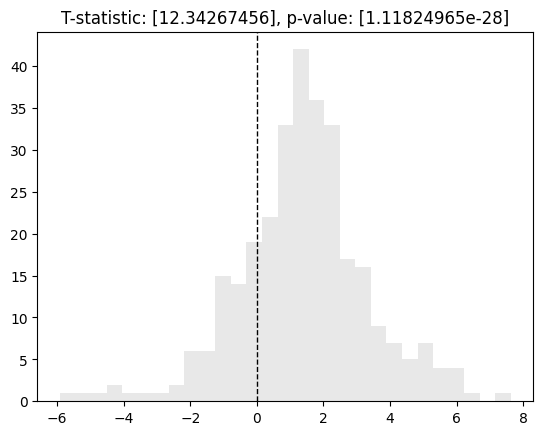

In [16]:
hit_ind = np.where(np.array(regressors_focus) == 'hit')[0][0]  # find the index of the hit
bins = np.linspace(np.nanmin(all_Tm[:, :, hit_ind]), np.nanmax(all_Tm[:, :, hit_ind]), 30)
# plt.hist(all_Tm[np.squeeze(all_pm[:, :, hit_ind]<0.05), :, hit_ind], bins=bins, color='r', alpha=0.5, edgecolor='none')
plt.hist(all_Tm[np.squeeze(all_pm[:, :, hit_ind]>=0), :, hit_ind], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
# single value tstat to test if significantly diff from 0
t_stat, p_val = stats.ttest_1samp(all_Tm[:, :, hit_ind], 0)
plt.title(f'T-statistic: {t_stat}, p-value: {p_val}')
plt.axvline(0, color='k', linestyle='--', linewidth=1)  # add a horizontal line at y=0
plt.savefig(os.path.join(beh_folder, f'hit_tstats.pdf'), bbox_inches='tight')

In [17]:
response_tbl = pd.DataFrame({'session': combined_tagged_units_filtered['session'],
                            'unit_id': combined_tagged_units_filtered['unit'],
                            'T': all_Tm[:, :, hit_ind].flatten(),
                            'p': all_pm[:, :, hit_ind].flatten(),
                            'coeffs': all_coefsm[:, :, hit_ind].flatten()})

In [18]:
response_tbl.to_csv(os.path.join(beh_folder, f'response_ratio_{criteria_name}_{align_name}.csv'), index=False)

In [19]:
os.path.join(beh_folder, f'response_ratio_{criteria_name}_{align_name}.csv')

'/root/capsule/scratch/combined/beh_plots/beh_all/response_ratio_beh_all_go_cue.csv'

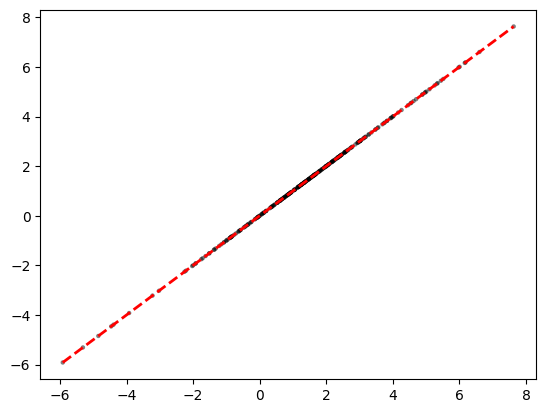

In [20]:
plt.scatter(response_tbl['T'], all_Tm[:, :, hit_ind], alpha=0.5, s=10, color='k', edgecolor='none')
plt.plot([np.nanmin(response_tbl['T']), np.nanmax(response_tbl['T'])],
            [np.nanmin(response_tbl['T']), np.nanmax(response_tbl['T'])], 
            color='r', linestyle='--', linewidth=2)